This code is a modification of https://github.com/chry-santhemum/R3

In [3]:
import os
import csv
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
import torch.nn.functional as F
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm.notebook import tqdm
import gym
from minigrid.wrappers import ObservationWrapper
from typing_extensions import Self
from copy import deepcopy
from blackjack_numerical_actions import BlackjackEnv

In [4]:
def get_device() -> torch.device:
    """
    Returns the device to use for training.
    """
    #return torch.device("cuda" if torch.cuda.is_available() else "cpu")
    return torch.device("cpu")

def set_random_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

# Function from https://github.com/ikostrikov/pytorch-a2c-ppo-acktr/blob/master/model.py
def init_params(m):
    """
    Initialize parameters of the network.
    m: torch.nn.Module
    """
    classname = m.__class__.__name__
    if classname.find("Linear") != -1:
        m.weight.data.normal_(0, 1)
        m.weight.data *= 1 / torch.sqrt(m.weight.data.pow(2).sum(1, keepdim=True))
        if m.bias is not None:
            m.bias.data.fill_(0)

class ImgObsWrapper(ObservationWrapper):
    """
    Use the image as the only observation output, no language/mission.

    Parameters:
    - env (gym.Env): The environment to wrap.

    Methods:
    - observation(self, obs): Returns the image from the observation.
    - reset(self): Resets the environment and returns the initial observation.
    """

    def __init__(self, env):
        """
        Initializes the ImgObsWrapper with the given environment.

        Parameters:
        - env (gym.Env): The environment whose observations are to be wrapped.
        """
        super().__init__(env)
        self.observation_space = env.observation_space.spaces["image"]

    def observation(self, obs):
        """
        Extracts and returns the image data from the observation.

        Parameters:
        - obs (dict or tuple): The original observation from the environment, which could be either
        a dictionary or a tuple containing a dictionary.

        Returns:
        - np.ndarray: The image data extracted from the observation.
        """
        if type(obs) == tuple:
            return obs[0]["image"]
        return obs["image"]

    def reset(self):
        """
        Resets the environment and returns the initial observation image.

        Returns:
        - np.ndarray: The initial observation image of the reset environment.
        """
        obs = super().reset()
        return obs[0]

class Config:
    """
    Stores algorithmic hyperparameters.
    """
    def __init__(self,
                score_threshold=0.93,
                discount=1,
                lr=1e-3,
                max_grad_norm=0.5,
                log_interval=10,
                gae_lambda=0.95,
                clip_ratio=0.2,
                target_kl=0.01,
                train_ac_iters=5,
                use_discounted_reward=True,
                use_gae=True,
                importance_sampling_clip=2.0,
                bad_fit_threshold=0.8,
                bad_fit_increment=None,
                replay_buffer_capacity=10,
                large_buffer_capacity=20):

        self.score_threshold = score_threshold # criterion for early stopping. If the rolling average reward (over the last 100 episodes) is greater than it, it ends.
        self.discount = discount # discount factor
        self.lr = lr # learning rate
        self.max_grad_norm = max_grad_norm # the maximum gradient norm (https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html)
        self.log_interval = log_interval # logging interval
        self.clip_ratio = clip_ratio # clip_ratio of PPO.
        self.target_kl = target_kl # target KL divergence for early stoping train_ac_iters for PPO
        self.train_ac_iters = train_ac_iters # how many time to train ac_model using current computed old_logps
        self.gae_lambda=gae_lambda # lambda in Generalized Advantage Estimation (GAE)
        self.use_discounted_reward=use_discounted_reward # whether use discounted reward or not.
        self.use_gae = use_gae # whether to use GAE or not.
        self.importance_sampling_clip = importance_sampling_clip # importance sampling clip threshold
        self.bad_fit_threshold = bad_fit_threshold # threshold for bad fit.
        if bad_fit_increment is None:
            bad_fit_increment = (1.0 - bad_fit_threshold) / replay_buffer_capacity
        self.bad_fit_increment = bad_fit_increment # increment for bad fit.
        self.replay_buffer_capacity = replay_buffer_capacity # capacity of replay buffer.
        self.large_buffer_capacity = large_buffer_capacity # capacity of large replay buffer.

class Machine:
    def __init__(self, entropy_coef, init_model:nn.Module, args:Config=None):
        """
        A Machine object consists of a Model and its entropy_coef

        Args:
            entropy_coef: Entropy coefficient.
            init_model: Initial model.
            args
        """
        if args is None:
            self.args = Config()
        else:
            self.args = args

        self.model = init_model
        self.optim = torch.optim.Adam(self.model.parameters(), lr=self.args.lr)
        self.coef = entropy_coef
        self.device = get_device()

    def copy_model(self, other_model:nn.Module) -> None:
        """
        Copy state dict from 'model'. Reset rs.
        """
        state_dict = other_model.state_dict()
        for key, v in state_dict.items():
            if key in self.model.state_dict():
                self.model.state_dict()[key].copy_(v)

    def copy_machine(self, other:Self) -> None:
        """
        Copy state dict from 'other'. Reset rs.
        """
        self.copy_model(other.model)

    def _compute_discounted_return(self, rewards):
        """
            rewards: reward obtained at timestep.  Shape: (T,)
            discount: discount factor. float

        ----
        returns: sum of discounted rewards. Shape: (T,)
        """
        returns = torch.zeros(*rewards.shape, device=self.device)

        R = 0
        for t in reversed(range((rewards.shape[0]))):
            R = rewards[t] + self.args.discount * R
            returns[t] = R
        return returns

    def _compute_advantage_gae(self, values, rewards, T):
        """
        Compute Adavantage wiht GAE. See Section 4.4.2 in the lecture notes.

        values: value at each timestep (T,)
        rewards: reward obtained at each timestep.  Shape: (T,)
        T: the number of frames, float
        gae_lambda: hyperparameter, float
        discount: discount factor, float

        -----

        returns:

        advantages : tensor.float. Shape [T,]

                    gae advantage term for timesteps 0 to T

        """
        advantages = torch.zeros_like(values)
        for i in reversed(range(T)):
            next_value = values[i+1]
            next_advantage = advantages[i+1]

            delta = rewards[i] + self.args.discount * next_value  - values[i]
            advantages[i] = delta + self.args.discount * self.args.gae_lambda * next_advantage
        return advantages[:T]

    def collect_experiences(self, env:gym.Env):
        """
        Collects rollouts and computes advantages.

        Returns
        -------
        exps : dict
            Contains actions, rewards, advantages etc as attributes.
            Each attribute, e.g. `exps['reward']` has a shape
            (self.num_frames, ...).
        logs : dict
            Useful stats about the training process, including the average
            reward, policy loss, value loss, etc.
        """
        device = get_device()

        MAX_FRAMES_PER_EP = 300
        shape = (MAX_FRAMES_PER_EP, )

        actions = torch.zeros(*shape, device=device, dtype=torch.int)
        values = torch.zeros(*shape, device=device)
        rewards = torch.zeros(*shape, device=device)
        log_probs = torch.zeros(*shape, device=device)
        obss = [None]*MAX_FRAMES_PER_EP

        obs = env.reset()

        total_return = 0

        T = 0

        while True:
            # Do one agent-environment interaction
            with torch.no_grad():
                dist, value = self.model(obs)

            dist: Categorical
            action = dist.sample()[0]

            obss[T] = obs

            obs, reward, done = env.step(action.item())

            # Update experiences values
            actions[T] = action
            values[T] = value
            rewards[T] = reward
            log_probs[T] = dist.log_prob(action)

            total_return += reward
            T += 1

            if done or T >= MAX_FRAMES_PER_EP-1:
                break

        success = (total_return > 0.5)

        discounted_reward = self._compute_discounted_return(rewards[:T])
        exps = dict(
            obs = torch.tensor(np.array(obss[:T]), device=device),
            action = actions[:T],
            value  = values[:T],
            reward = rewards[:T],
            log_prob = log_probs[:T],
            discounted_reward = discounted_reward,
            T = T
        )

        logs = {
            "return_per_episode": total_return,
            "num_frames": T,
            'success': success
        }

        return exps, logs

    def _compute_policy_loss_ppo(self, dist:Categorical, factors, indices, old_logp, actions, advantages):
        """
        Computes the policy loss for PPO.

        obs: observeration to pass into acmodel. shape: (T,)
        init_logp: log probabilities we get from the agent performing the action. shape: (T,)
        old_logp: log probabilities from previous timestep. shape: (T,)
        actions: action at this timestep. shape: (T,ImWidth,ImHeight,Channels)
        advantages: the computed advantages. shape: (T,)

        ---
        returns

        policy_loss : ppo policy loss as shown in line 6 of PPO alg. tensor.float. Shape (,1)
        approx_kl: an appoximation of the kl_divergence. tensor.float. Shape (,1)
        """
        policy_loss, approx_kl = 0, 0

        coef = self.coef

        entropy = dist.entropy()
        logps = dist.log_prob(actions)
        r_terms = torch.exp(logps - old_logp)
        ppo_loss = torch.min(r_terms * advantages, torch.clamp(r_terms, 1 - self.args.clip_ratio, 1 + self.args.clip_ratio) * advantages)

        policy_loss_tensor = factors * ppo_loss + coef * entropy

        policy_loss = - torch.mean(policy_loss_tensor[indices])

        # approx_kl = torch.sum(torch.exp(old_logp) * (old_logp - logps)) / torch.sum(torch.exp(old_logp))
        approx_kl = torch.mean((old_logp - logps) ** 2) / 2

        return policy_loss, approx_kl

    def _compute_value_loss(self, values, returns):
        value_loss = torch.mean((values - returns) ** 2)

        return value_loss

    def update_parameters(self, sb, update_v=True):
        MAX_FRAMES_PER_EP = 300
        T = sb['T']
        with torch.no_grad():
            dist, values = self.model(sb['obs'])
        values = values.reshape(-1)
        dist: Categorical
        old_logp = dist.log_prob(sb['action'])
        init_logp = sb['log_prob']

        # add 0 to end of values until it has length MAX_FRAMES_PER_EP
        values_extended = torch.cat([values, torch.zeros((MAX_FRAMES_PER_EP - len(values), ), device=get_device())], dim=0)
        full_reward = torch.cat([sb['reward'], torch.zeros((MAX_FRAMES_PER_EP - len(sb['reward']), ), device=get_device())], dim=0)

        if self.args.use_gae:
            advantage = self._compute_advantage_gae(values_extended, full_reward, T)
        else:
            advantage = sb['discounted_reward'] - values.reshape(-1)

        for i in range(self.args.train_ac_iters):
            self.optim.zero_grad()
            dist, values = self.model(sb['obs'])
            values = values.reshape(-1)
            # policy loss
            factors = torch.exp(old_logp - init_logp)
            indices = factors < self.args.importance_sampling_clip
            fit = torch.mean(indices.to(torch.float32))

            loss_pi, approx_kl = self._compute_policy_loss_ppo(dist, factors, indices, old_logp, sb['action'], advantage)
            if update_v:
                loss_v = self._compute_value_loss(values, sb['discounted_reward'])
            else:
                loss_v = 0.0

            if i == 0:
                policy_loss = loss_pi
                value_loss = loss_v

            loss = loss_v + loss_pi
            if approx_kl > 1.5 * self.args.target_kl:
                break

            loss.backward(retain_graph=True)
            self.optim.step()

        update_policy_loss = policy_loss.item()
        update_value_loss = value_loss.item()

        logs = {
            "policy_loss": update_policy_loss,
            "value_loss": update_value_loss,
            "fit": fit.item()
        }

        return logs

    def decrease_prob(self, sb, lr=0.1) -> None:
        self.optim.zero_grad()

        dist, _ = self.model(sb['obs'])
        dist: Categorical
        logps = dist.log_prob(sb['action'])

        loss = lr * torch.mean(logps)
        loss.backward()
        self.optim.step()

class PPO:
    def __init__(self, ACModelClass, env, args:Config=None, seed=0):
        """
        The PPO agent.
        """

        self.env = env

        set_random_seed(seed)
        model = ACModelClass(use_critic=True).to(get_device())

        if args is None:
            args = Config()
        self.machine = Machine(0.01, model, args)

    def train(self, max_episodes:int=10000, nonstop:bool=False, max_frames=float('inf')) -> tuple[list[int], list[float]]:
        """
        Train the PPO agent.

        Returns:
            num_frames, smooth_rs
        """

        print(f'Start! Agent: PPO.')

        is_solved = False

        SMOOTH_REWARD_WINDOW = 3000

        rewards = [0]*SMOOTH_REWARD_WINDOW

        total_smooth_rs = []
        total_num_frames = []

        num_frames = 0

        pbar = tqdm(range(max_episodes))
        for update in pbar:

            exps, logs1 = self.machine.collect_experiences(self.env)

            logs2 = self.machine.update_parameters(exps)

            logs = {**logs1, **logs2}

            total_num_frames.append(num_frames)
            num_frames += logs["num_frames"]

            rewards.append(logs["return_per_episode"])

            smooth_reward = np.mean(rewards[-SMOOTH_REWARD_WINDOW:])

            total_smooth_rs.append(smooth_reward)

            data = {'num_frames':num_frames, 'smooth_reward':smooth_reward,
                'reward':logs["return_per_episode"], 'policy_loss':logs["policy_loss"], 'value_loss': logs['value_loss'], 'episode':update}

            pbar.set_postfix(data)

            if not nonstop and smooth_reward >= self.machine.args.score_threshold:
                is_solved = True
                break
            if num_frames >= max_frames:
                break

        if not nonstop and is_solved:
            print('Solved!')

        return total_num_frames, total_smooth_rs

# create a replay buffer
class CyclicBuffer:
    def __init__(self, capacity):
        self.buffer = []
        self.capacity = capacity
        self.cur_pos = 0

    def __len__(self):
        return len(self.buffer)

    def __getitem__(self, item):
        return self.buffer[item]

    def append(self, data):
        """
        Adds a new piece of data to the buffer.

        Parameters:
        - data: The data to be added to the buffer.
        """
        #### TODO (10pts): add data to the buffer
        #### if the buffer is not full yet, you can simply append the data to the buffer
        #### otherwise, you need to replace the oldest data with the current data (FIFO)
        #### Hint: you may find self.cur_pos useful, it can be used as a position index
        #### to keep track of where to add data
        if len(self.buffer) < self.capacity:
            self.buffer.append(data)
            self.cur_pos = (self.cur_pos + 1) % self.capacity
        else:
            self.buffer[self.cur_pos] = data
            self.cur_pos = (self.cur_pos + 1) % self.capacity

    def sample(self, batch_size):
        """
        Randomly selects a batch of data from the buffer. The size of the batch is the minimum of the requested
        batch size and the current size of the buffer. If the requested batch size equals the buffer size, all
        data in the buffer is returned.

        Parameters:
        - batch_size (int): The size of the batch to sample.

        Returns:
        - list: A list containing the sampled batch of data.
        """
        #### TODO (10pts): sample a batch from the buffer
        bs = min(batch_size, len(self.buffer))
        return random.sample(self.buffer, bs)

    def get_all(self):
        """
        Retrieves all data stored in the buffer.

        Returns:
        - list: A deepcopy of all data currently stored in the buffer.
        """
        return deepcopy(self.buffer)

    def clear(self):
        """
        Removes all data from the buffer, effectively resetting its state.
        """
        self.buffer.clear()
        self.cur_pos = 0

def get_default_config():
    config = dict(
        learning_rate=0.00025,
        gamma=0.99,
        memory_size=200000,
        initial_epsilon=1.0,
        min_epsilon=0.1,
        max_epsilon_decay_steps=150000,
        warmup_steps=500,
        target_update_freq=2000,
        batch_size=32,
        device=None,
        disable_target_net=False,
        enable_double_q=True
    )
    return config

class RRR:
    def __init__(self, ACModelClass, env, args:Config=None, seed=0):
        """
        The RRR agent.
        """

        self.env = env

        set_random_seed(seed)
        m1 = ACModelClass(use_critic=True).to(get_device())

        if args is None:
            args = Config()

        self.exploiter = Machine(0.01, m1, args)

        m2 = ACModelClass(use_critic=False).to(get_device())
        m3 = ACModelClass(use_critic=False).to(get_device())
        m4 = ACModelClass(use_critic=False).to(get_device())

        self.explorer_random = Machine(0.03, m2, args)
        self.explorer_thirsty = Machine(0.02, m3, args)
        self.explorer_thirsty.copy_machine(self.exploiter)

        self.temp_machine = Machine(0.01, m3, args)
        self.explorer_bengbuzhu = Machine(0.5, m4, args)

    def _replay(self, machine:Machine, buffer:list, cutoff:float) -> float:
        """
        Replay random sample from buffer on machine.

        Args:
            machine: Machine to replay on
            buffer: list of experiences
            cutoff: if fit < cutoff, delete sb from buffer

        Returns:
            fit
        """

        idx = np.random.randint(len(buffer))
        sb = buffer[idx]
        logs_replay = machine.update_parameters(sb)
        fit = logs_replay['fit']
        if fit < cutoff:
            # delete sb from buffer
            buffer.pop(idx)

        return fit

    def _add_sb_to_buffer(self, exps, buffer:list, capacity:int) -> None:
        buffer.append(exps)
        if len(buffer) > capacity:
            buffer.pop(0)


    def train(self, max_episodes:int=10000, nonstop:bool=False, max_frames=float('inf')) -> tuple[list[int], list[float], list[float]]:
        """
        Train the agent.

        Returns:
            num_frames, smooth_rs, fits
        """

        print('Start! Agent: RRR.')
        RANDOM_MODE = 0
        EXPLORE_MODE = 1
        EXPLOIT_MODE = 2
        mode = RANDOM_MODE

        is_solved = False

        SMOOTH_REWARD_WINDOW = 3000

        rewards = [0]*SMOOTH_REWARD_WINDOW

        total_smooth_rs = []
        total_num_frames = []
        larger_buffer_r = []
        buffer_r = []
        buffer_no_r = []
        fits = []

        num_frames = 0

        pbar = tqdm(range(max_episodes))
        for update in pbar:
            total_num_frames.append(num_frames)

            if mode == RANDOM_MODE:
                exps, logs1 = self.explorer_bengbuzhu.collect_experiences(self.env)
                self.explorer_bengbuzhu.update_parameters(exps)
                logs2 = self.exploiter.update_parameters(exps)

            elif mode == EXPLORE_MODE:
                if np.random.rand() < 0.5:
                    m = self.explorer_random
                else:
                    m = self.explorer_thirsty

                exps, logs1 = m.collect_experiences(self.env)

                m.update_parameters(exps)
                logs2 = self.exploiter.update_parameters(exps)

                if len(larger_buffer_r) >= 1:
                    self._replay(self.explorer_thirsty, larger_buffer_r, cutoff=0.0)

            elif mode == EXPLOIT_MODE:
                exps, logs1 = self.exploiter.collect_experiences(self.env)

                logs2 = self.exploiter.update_parameters(exps)

                assert len(buffer_r) > 0, f'buffer_r should not be empty.'

                cutoff = self.exploiter.args.bad_fit_threshold + self.exploiter.args.bad_fit_increment * (len(buffer_r) - 1)

                if not logs1['success'] and total_smooth_rs[-1] <= 0.5:
                    fit = self._replay(self.exploiter, buffer_r, cutoff)
                    fits.append(fit)

                if len(buffer_r) == 0:
                    print(f'At episode {update}, we lost all data in replay buffer...')
                    mode = EXPLORE_MODE
                    self.explorer_thirsty.copy_machine(self.exploiter)
                    self.explorer_random.copy_machine(self.temp_machine)
                    self.temp_machine.copy_machine(self.exploiter)

            else:
                raise ValueError(f'Invalid mode: {mode}')

            logs = {**logs1, **logs2}

            num_frames += logs["num_frames"]

            rewards.append(logs["return_per_episode"])

            if logs['success']:
                if mode == RANDOM_MODE:
                    print(f'First successful data collected at episode {update}! We will be accelerating.')
                elif mode == EXPLORE_MODE:
                    if m is self.explorer_random:
                        info_print = 'random explorer'
                    elif m is self.explorer_thirsty:
                        info_print = 'thirsty explorer'
                    else:
                        raise ValueError(f'Invalid explorer: {m}')

                    print(f'At episode {update}, {info_print} collected a successful data.')
                elif mode == EXPLOIT_MODE:
                    pass
                else:
                    raise ValueError(f'Invalid mode: {mode}')
                self._add_sb_to_buffer(exps, buffer_r, self.exploiter.args.replay_buffer_capacity)
                self._add_sb_to_buffer(exps, larger_buffer_r, self.exploiter.args.large_buffer_capacity)
                mode = EXPLOIT_MODE
            else:
                self._add_sb_to_buffer(exps, buffer_no_r, self.exploiter.args.replay_buffer_capacity)

            smooth_reward = np.mean(rewards[-SMOOTH_REWARD_WINDOW:])

            total_smooth_rs.append(smooth_reward)

            data = {'num_frames':num_frames, 'smooth_reward':smooth_reward,
                'reward':logs["return_per_episode"], 'episode':update}

            pbar.set_postfix(data)

            if not nonstop and smooth_reward >= self.exploiter.args.score_threshold:
                    is_solved = True
                    break
            if num_frames >= max_frames:
                break

        if is_solved:
            print('Solved!')

        return total_num_frames, total_smooth_rs, fits

class ACModel(nn.Module):
    def __init__(self, use_critic=False, state_dim=3, action_dim=2, hidden_dim=256, dropout_p=0.2):
        """
        Actor-Critic model for flat, vector-based inputs (e.g., Blackjack).

        Parameters:
        - use_critic (bool): Whether to include a critic network.
        - state_dim (int): Dimensionality of the input state (default 3).
        - action_dim (int): Number of discrete actions (default 5 for Blackjack).
        """
        super().__init__()
        self.use_critic = use_critic

        # Actor network
        self.actor = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim),
            nn.Dropout(dropout_p),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim),
            nn.Dropout(dropout_p),
            nn.Linear(hidden_dim, action_dim)
        )

        # Critic network (optional)
        if use_critic:
            self.critic = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim),
            nn.Dropout(dropout_p),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim),
            nn.Dropout(dropout_p),
            nn.Linear(hidden_dim, 1)
            )

    def forward(self, obs):
        """
        Forward pass through the Actor-Critic model.

        Parameters:
        - obs (torch.Tensor): Batch of state vectors, shape [batch_size, state_dim].

        Returns:
        - dist (torch.distributions.Categorical): Action distribution.
        - value (torch.Tensor): State value estimate (shape: [batch_size]).
        """
        if not isinstance(obs, torch.Tensor):
            obs = torch.tensor(obs, dtype=torch.float32)
        if len(obs.shape) == 1:
            obs = obs.unsqueeze(0)

        logits = self.actor(obs)
        dist = Categorical(logits=F.log_softmax(logits, dim=-1))

        if self.use_critic:
            value = self.critic(obs).squeeze(-1)
        else:
            value = torch.zeros(obs.shape[0])

        return dist, value

In [5]:
seed = 42

env = BlackjackEnv(
        num_decks=6,
        dealer_hits_soft_17=False,
        allow_double=False,
        allow_split=False,
        allow_surrender=False
    )

set_random_seed(seed)

config = Config(bad_fit_threshold=0.01, importance_sampling_clip=2.0)

Start! Agent: RRR.


  0%|          | 0/40000 [00:00<?, ?it/s]

First successful data collected at episode 0! We will be accelerating.
Start! Agent: PPO.


  0%|          | 0/40000 [00:00<?, ?it/s]

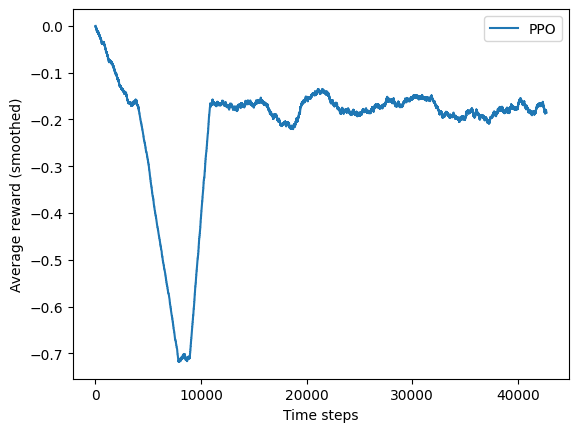

In [6]:
max_episodes = 40000

agent_RRR = RRR(ACModel, env=env, args=Config(bad_fit_threshold=0.01, importance_sampling_clip=2.0), seed=seed)
agent_PPO = PPO(ACModel, env=env, args=config, seed=seed)

num_frames_RRR, smooth_rs_RRR, fits_RRR = agent_RRR.train(max_episodes, nonstop=True)
num_frames_PPO, smooth_rs_PPO = agent_PPO.train(max_episodes, nonstop=True)

plt.figure()
plt.plot(num_frames_PPO, smooth_rs_PPO, label='PPO')
#plt.plot(num_frames_RRR, smooth_rs_RRR, label='R3')
plt.xlabel('Time steps')
plt.ylabel('Average reward (smoothed)')
plt.legend()
plt.show()

In [7]:
def generate_strategy_csv(agent, model_type = 'RRR', filename_prefix="RRR_strategy"):
    """
    Generate a strategy table (hard/soft hands) using the policy from RRR.exploiter.model.

    Parameters:
    - agent_rrr: an instance of RRR.
    - filename_prefix: Prefix for the saved CSV files.
    """
    player_sums = list(range(4, 22))
    dealer_cards = list(range(1, 11))
    output_dir = "strategyTable"
    os.makedirs(output_dir, exist_ok=True)

    # Get the actor model from the RRR exploiter's Machine instance
    if model_type == 'RRR':
        policy_model = agent.exploiter.model
    elif model_type == 'PPO':
        policy_model = agent.machine.model


    for usable in [False, True]:
        table = []
        header = ["Player Sum \\ Dealer Card"] + [str(dealer) for dealer in dealer_cards]
        table.append(header)

        for player_sum in player_sums:
            row = [str(player_sum)]
            for dealer in dealer_cards:
                # Normalize inputs just like in training
                state = np.array([player_sum / 21, ((dealer - 2) % 10) / 9, int(usable)], dtype=np.float32)
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(get_device())

                with torch.no_grad():
                    dist, _ = policy_model(state_tensor)
                    action = torch.argmax(dist.probs).item()

                row.append(action)
            table.append(row)

        suffix = "soft" if usable else "hard"
        filename = os.path.join(output_dir, f"{filename_prefix}_{suffix}.csv")
        with open(filename, mode='w', newline='') as f:
            writer = csv.writer(f)
            writer.writerows(table)

        print(f"Strategy table ({suffix}) saved to: {filename}")

In [8]:
generate_strategy_csv(agent_RRR, model_type='RRR', filename_prefix="RRR_strategy")

Strategy table (hard) saved to: strategyTable\RRR_strategy_hard.csv
Strategy table (soft) saved to: strategyTable\RRR_strategy_soft.csv


In [9]:
generate_strategy_csv(agent_PPO, model_type='PPO', filename_prefix="PPO_strategy")

Strategy table (hard) saved to: strategyTable\PPO_strategy_hard.csv
Strategy table (soft) saved to: strategyTable\PPO_strategy_soft.csv
